In [1]:
import os
import torch

import matplotlib.pyplot as plt
from tqdm import trange
from models.ESN import ESNModel
from dataset.data_loaders import load_dataset, generate_datasets
from models.early_stopping import EarlyStopping


os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Data

In [6]:
data, L, F = load_dataset('spain')

Xtr, Ytr, Xval, Yval, Xte, Yte, diffXte, diffYte = generate_datasets(data, L, F, device, test_percent = 0.25, val_percent = 0.25)


In [ ]:
batch = 32
steps = Xtr[:,0].shape[0]

X = torch.stack([Xtr[i:i+batch,0] for i in range(steps-batch+1)]).T.reshape((batch,steps-batch+1,1,1))
Xv = Xval[:,0].reshape((1,Xval[:,0].shape[0],1,1))
Xt = Xte[:,0].reshape((1,Xte[:,0].shape[0],1,1))

In [28]:
X = torch.stack([Xtr[i:i+batch,0] for i in range(steps-batch+1)]).T.reshape((batch,steps-batch+1,1,1))

In [29]:
X.shape

torch.Size([32, 876, 1, 1])

In [30]:
Ytr.shape

torch.Size([907, 1])

In [35]:
esn = ESNModel(batch, 500, 1, 0, 1, F).to(device)

In [36]:
esn(X).shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1 and 32x500)

In [4]:
torch_optimizer = torch.optim.Adam(esn.parameters(), lr=0.01, weight_decay=1e-5)
epochs = 100
torch_loss = torch.nn.MSELoss()

# initialize the early_stopping object
checkpoint_path = "./checkpoints/QR/"
early_stopping = EarlyStopping(patience=20, verbose=False, path=checkpoint_path)

with trange(epochs) as t:
    for epoch in t:
        esn.train()
        torch_optimizer.zero_grad()
        loss = torch_loss(esn(X).squeeze(), Ytr.squeeze())
        loss.backward()
        torch_optimizer.step()

        # display progress bar
        t.set_description(f"Epoch {epoch+1}")
        t.set_postfix({"loss":float(loss / Ytr.shape[0])})

        # Early stopping
        esn.eval()
        valid_loss = torch_loss(esn(Xv).squeeze(), Yval.squeeze()).item()

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, esn)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

# load the last checkpoint with the best model
esn.load_state_dict(torch.load(checkpoint_path + "checkpoint.pt"))

Epoch 1:   0%|          | 0/100 [00:03<?, ?it/s, loss=0.00127]c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([455])) that is different to the input size (torch.Size([907])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1:   0%|          | 0/100 [00:03<?, ?it/s, loss=0.00127]


RuntimeError: The size of tensor a (907) must match the size of tensor b (455) at non-singleton dimension 0

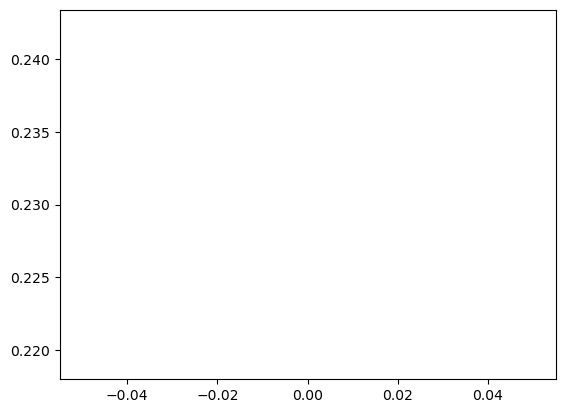

In [35]:
out = esn(Xt).squeeze().detach().cpu()

plt.plot(out)
# plt.plot(Yte.squeeze().cpu())